In [1]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import yfinance
import matplotlib.ticker as mticker
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from mplfinance.original_flavor import candlestick_ohlc


In [95]:
stocks = ['AAPL' ]
# , 'MSFT', 'AMD' , 'FB' , 'AMZN' , 'ADSK' , 'ANSS' ,  'AVGO' , 'AZN' , 'FISV' , 'GILD' , 'KHC' , 'NFLX' , 'OKTA' , 'REGN'
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 2 )

for stock in stocks:
  df = yfinance.download(stock , startDate , endDate )
  del df['Volume']
  del df['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [96]:
from scipy.signal import argrelextrema

local_max = argrelextrema(df['High'].values, np.greater, order = 7)
local_min = argrelextrema(df['Low'].values, np.less , order = 7)

In [97]:
highs = df.iloc[local_max[0] , :]
lows = df.iloc[local_min[0] , :]

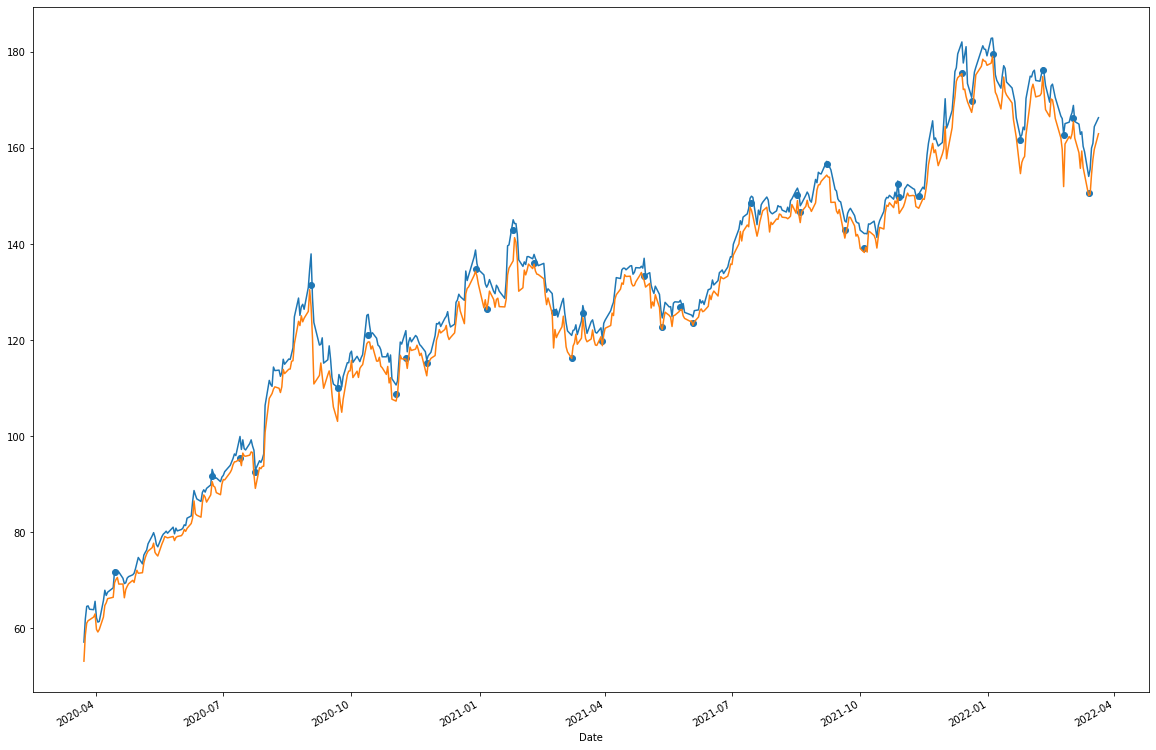

In [111]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[20,14])
highslows = pd.concat([highs,lows])
df['High'].plot()
df['Low'].plot()
plt.scatter(highslows.index, highslows['Close'] )  

<AxesSubplot:xlabel='Date'>

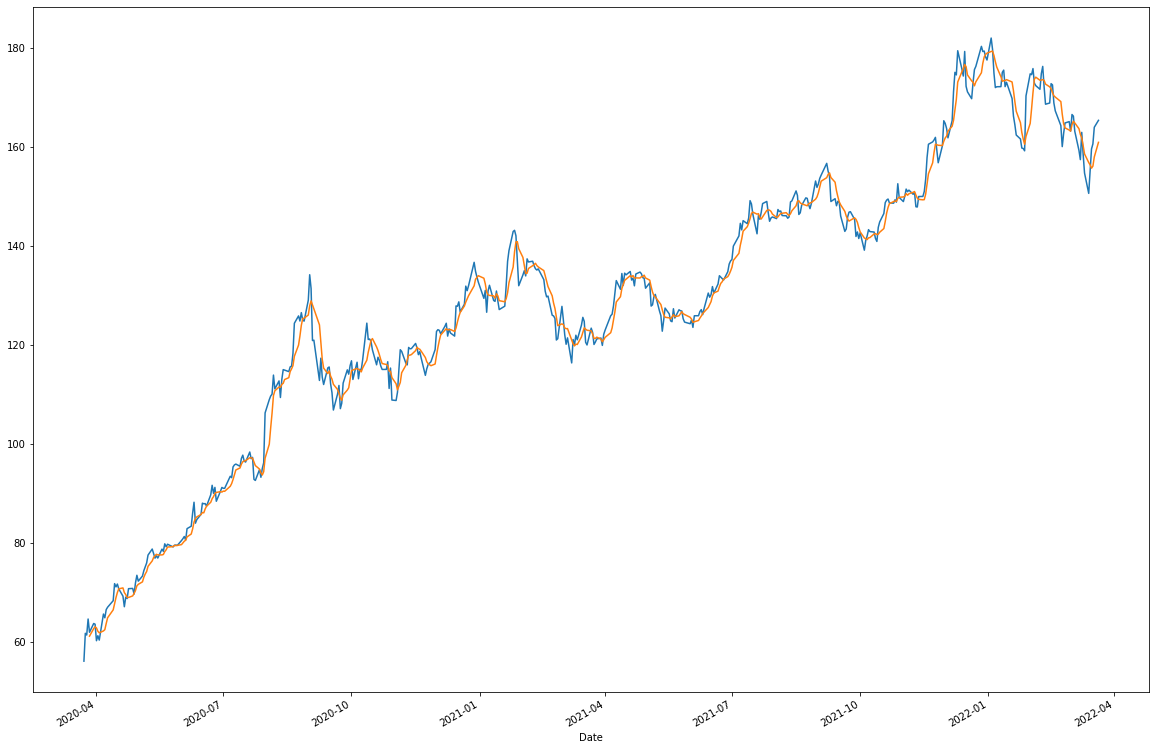

In [112]:
fig = plt.figure(figsize=[20,14])
df['Close'].plot()
df['Close'].rolling(window=5).mean().plot()

In [141]:
del df['High']
del df['Low']
del df['Open']

In [142]:
prices = df.copy()
prices = prices.reset_index()
prices.columns = ['date', 'price']
prices = prices['price']

In [132]:
len(df['Close'].values)

504

<AxesSubplot:xlabel='Date'>

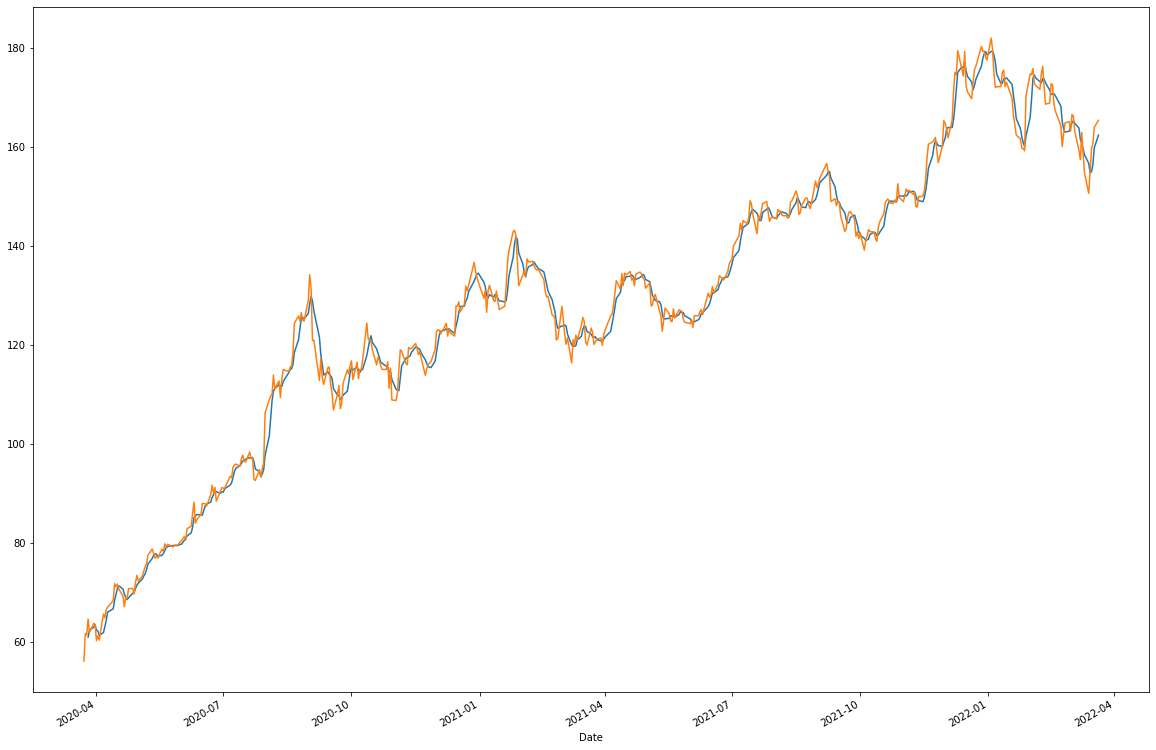

In [145]:
from statsmodels.nonparametric.kernel_regression import KernelReg

fig = plt.figure(figsize=[20,14])
kr = KernelReg([prices.values], [prices.index.to_numpy()], var_type='c')
f = kr.fit([prices.index])

df['Close'].rolling(window=4).mean().plot()
smooth_prices = pd.Series(data=f[0], index=df.index)
smooth_prices.plot()

In [148]:
# Use smoothed prices to determine local minima and maxima
smooth_prices = pd.Series(data=f[0], index=prices.index)
smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
local_max_min = np.sort(
    np.concatenate([smooth_local_max, smooth_local_min]))
smooth_extrema = smooth_prices.loc[local_max_min]

In [151]:
 # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
price_local_max_dt = []
for i in smooth_local_max:
    if (i > 1) and (i < len(prices)-1):
        price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

price_local_min_dt = []
for i in smooth_local_min:
    if (i > 1) and (i < len(prices)-1):
        price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

maxima = pd.Series(prices.loc[price_local_max_dt])
minima = pd.Series(prices.loc[price_local_min_dt])
extrema = pd.concat([maxima, minima]).sort_index()

# Return series for each with bar as index
# return extrema, prices, smooth_extrema, smooth_prices


In [154]:
def find_patterns(extrema, max_bars=35):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (max(e1, e3, e5) > min(e2, e4)):

            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns

In [157]:
def plot_window(prices, extrema, smooth_prices, smooth_extrema, ax=None):
    """
    Input: data from find_extrema
    Output: plots window for actual and smoothed prices and extrema
    """
    if ax is None:
        fig = plt.figure(figsize=[20,14])
        ax = fig.add_subplot(111)

    prices.plot(ax=ax, color='dodgerblue')
    ax.scatter(extrema.index, extrema.values, color='red')
    smooth_prices.plot(ax=ax, color='lightgrey')
    ax.scatter(smooth_extrema.index, smooth_extrema.values, color='lightgrey')

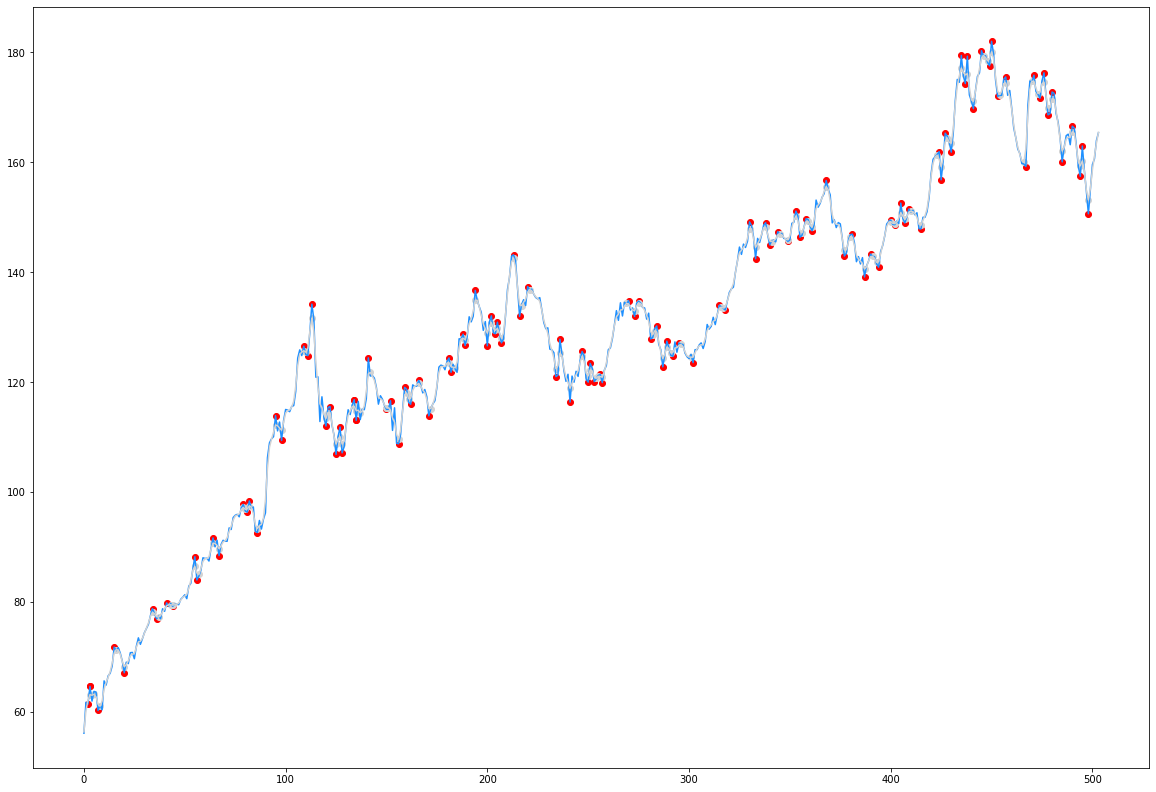

In [158]:
plot_window(prices, extrema, smooth_prices, smooth_extrema)